In [1]:
import mechwolf as mw
from datetime import timedelta

# define vessels
hatu = mw.Vessel("HATU")
dmf = mw.Vessel("DMF")
output = mw.Vessel("waste")
diea = mw.Vessel("DIEA")
pip = mw.Vessel("40% Piperidine in DMF")

# define pumps
activator_pump = mw.Pump()
amino_pump = mw.Pump()
diea_pump = mw.Pump()

mixer = mw.TMixer(name='mixer')

# define sensors
uv = mw.Sensor()

# define amines
fmoc_pna_a = mw.Vessel("fmoc_pna_a")
fmoc_pna_t = mw.Vessel("fmoc_pna_t")
fmoc_pna_c = mw.Vessel("fmoc_pna_c")
fmoc_pna_g = mw.Vessel("fmoc_pna_g")
fmoc_lys_oh = mw.Vessel("fmoc_lys_oh")
syringe_6 = mw.Vessel("syringe_6")
ala = mw.Vessel("ala")
leu = mw.Vessel("leu")
phe = mw.Vessel("phe")

# define valve
amino_mapping = {fmoc_pna_a: 1,
                     fmoc_pna_t: 2,
                     fmoc_pna_c: 3,
                     fmoc_pna_g: 4,
                     fmoc_lys_oh: 5,
                     syringe_6: 6,
                     ala: 7,
                     leu: 8,
                     phe: 9,
                     dmf: 10}

amino_valve = mw.Valve(mapping=amino_mapping)


activator_valve = mw.Valve(mapping={hatu: 1, pip: 9, dmf: 10})


def fat_tube(len):
    return mw.Tube(length=len, ID="1/16 in", OD="1/8 in", material="PFA")

def thin_tube(len):
    return mw.Tube(length=len, ID="0.030 in", OD="1/16 in", material="PFA")

def thinner_tube(len):
    return mw.Tube(length=len, ID="0.020 in", OD="1/16 in", material="PFA")


valve_tube = thinner_tube("12 cm")

A = mw.Apparatus("Peptide Nucleic Acid Synthesizer")

A.add(hatu, activator_valve, fat_tube("101 cm"))
A.add([dmf, pip], activator_valve, fat_tube("101 cm"))
A.add(activator_valve, activator_pump, valve_tube)
A.add(activator_pump, mixer, thinner_tube("46 cm"))
A.add(fmoc_pna_a, amino_valve, thin_tube("64.9 cm"))
A.add(fmoc_pna_t, amino_valve, thin_tube("53 cm"))
A.add(fmoc_pna_c, amino_valve, thin_tube("46.2 cm"))
A.add(fmoc_pna_g, amino_valve, thin_tube("44 cm"))
A.add(fmoc_lys_oh, amino_valve, thin_tube("36.1 cm"))
A.add(syringe_6, amino_valve, thin_tube("31 cm"))
A.add(ala, amino_valve, thin_tube("25.6 cm"))
A.add(leu, amino_valve, thin_tube("25 cm"))
A.add(phe, amino_valve, thin_tube("28.8 cm"))
A.add(dmf, amino_valve, fat_tube("113 cm"))
A.add(amino_valve, amino_pump, valve_tube)
A.add(amino_pump, mixer, thinner_tube("46 cm"))
A.add(diea, diea_pump, fat_tube("98 cm"))
A.add(diea_pump, mixer, thinner_tube("65 cm"))
A.add(mixer, uv, thinner_tube("40 cm"))

In [6]:
peptide = [ala]

In [7]:

#A.describe()
#A.visualize(graph_attr=dict(splines="ortho", nodesep="0.75"), label_tubes=False)

P = mw.Protocol(A)
start = timedelta(seconds=0)

# how much time to leave the pumps off before and after switching the valve
switching_time = timedelta(seconds=1)



def pump_time(number_strokes, flow_rate=5):
    # Computes the length of time to run the Varian Prostar pump with a 5 mL/min pump head at the desired flow rate
    # to get the desired number of pump delivery cycles (pump strokes). The volume of each
    # pump stroke is 0.039239 mL.
    # Returns time in minutes.
    time_seconds = 60 * ((number_strokes * 0.039239) / flow_rate)
    return time_seconds


def add_rinse(time_seconds):
    global start
    rinse_duration = timedelta(seconds=time_seconds) + 2 * switching_time
    P.add([amino_valve, activator_valve], start=start, duration=rinse_duration, setting=dmf)
    P.add([amino_pump, activator_pump], start=start + switching_time, duration=rinse_duration - 2 * switching_time, rate="5 mL/min")
    start += rinse_duration


def add_diea_rinse(time_seconds):
    # Washes with all three pumps while coupling agent and amino acid flushes out
    global start
    rinse_duration = timedelta(seconds=time_seconds) + 2 * switching_time
    P.add([amino_valve, activator_valve], start=start, duration=rinse_duration, setting=dmf)
    P.add([amino_pump, activator_pump, diea_pump], start=start + switching_time, duration=rinse_duration - 2 * switching_time, rate="5 mL/min")

    start += rinse_duration

P.add(uv, start = start, rate = "5 Hz")

add_rinse(10)
for amino in reversed(peptide):

    # Turn on amino acid, coupling agent, and diea. does not implement about a priming period
    coupling_duration = timedelta(seconds=(pump_time(number_strokes=10))) + 2 * switching_time

    P.add(amino_valve, start=start, duration=coupling_duration, setting=amino)
    P.add(activator_valve, start=start, duration=coupling_duration, setting=hatu)
    P.add([amino_pump, activator_pump, diea_pump], start=start + switching_time, duration=coupling_duration - 2 * switching_time, rate="5 mL/min")

    start += coupling_duration

    add_diea_rinse(pump_time(number_strokes=5))
    add_rinse(30)

    # Fmoc removal
    pip_addition_duration = timedelta(seconds=10) + 2 * switching_time

    P.add([amino_pump, activator_pump], start=start + switching_time, duration=pip_addition_duration - 2 * switching_time, rate="5 mL/min")
    P.add(amino_valve, start=start, duration=pip_addition_duration, setting=dmf)
    P.add(activator_valve, start=start, duration=pip_addition_duration, setting=pip)

    start += pip_addition_duration

    add_rinse(30)

add_rinse(10)
add_rinse(10)




In [11]:
P.compile()

/Users/BenjaminLee/Desktop/Python/Research/flow-chem/flow-chem/mechwolf/core/protocol.py:317: UserWarning: Automatically inferring stop for Sensor Sensor_0 as the end of the protocol. To override, provide stop in your call to add().
  f"Automatically inferring stop for {procedure['component']} as "


{<Pump Pump_2>: [{'time': 13.0, 'params': {'rate': '5 mL/min'}},
  {'time': 17.70868, 'params': {'rate': '0 mL/min'}},
  {'time': 19.70868, 'params': {'rate': '5 mL/min'}},
  {'time': 22.06302, 'params': {'rate': '0 mL/min'}}],
 <Pump Pump_1>: [{'time': 1.0, 'params': {'rate': '5 mL/min'}},
  {'time': 11.0, 'params': {'rate': '0 mL/min'}},
  {'time': 13.0, 'params': {'rate': '5 mL/min'}},
  {'time': 17.70868, 'params': {'rate': '0 mL/min'}},
  {'time': 19.70868, 'params': {'rate': '5 mL/min'}},
  {'time': 22.06302, 'params': {'rate': '0 mL/min'}},
  {'time': 24.06302, 'params': {'rate': '5 mL/min'}},
  {'time': 54.06302, 'params': {'rate': '0 mL/min'}},
  {'time': 56.06302, 'params': {'rate': '5 mL/min'}},
  {'time': 66.06302, 'params': {'rate': '0 mL/min'}},
  {'time': 68.06302, 'params': {'rate': '5 mL/min'}},
  {'time': 98.06302, 'params': {'rate': '0 mL/min'}},
  {'time': 100.06302, 'params': {'rate': '5 mL/min'}},
  {'time': 110.06302, 'params': {'rate': '0 mL/min'}},
  {'time': 1

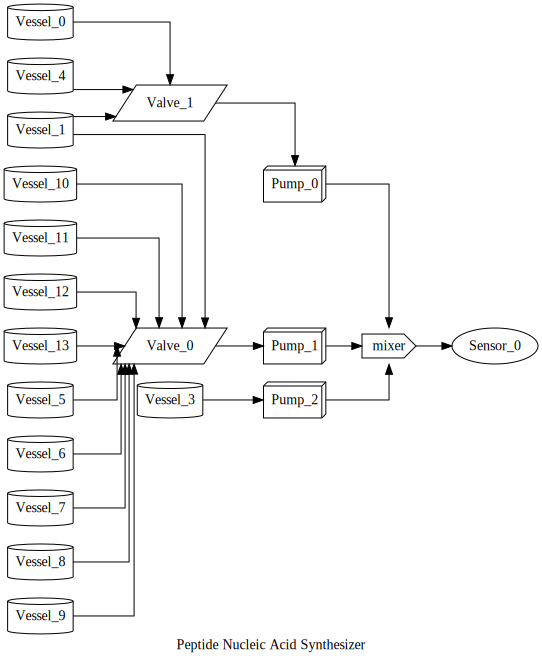

In [12]:
A.visualize()